Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Evaluating Linear Regression with LOO
  Mean Squared Error (MSE): 70.53
  R² Score: 0.43


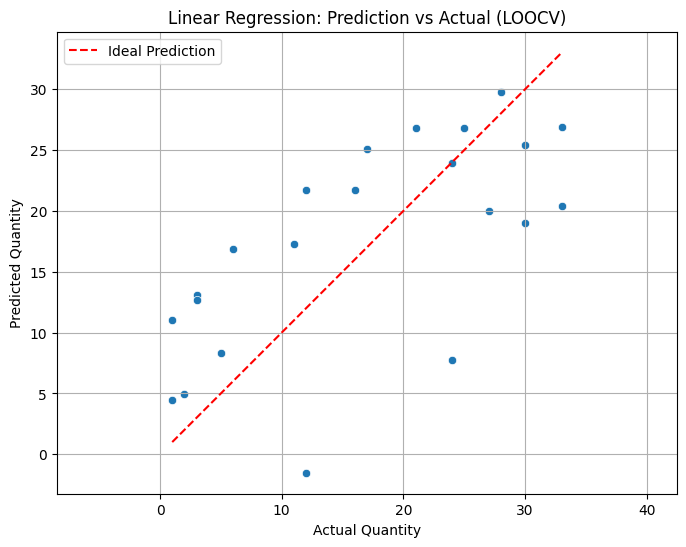


Evaluating Random Forest with LOO
  Mean Squared Error (MSE): 26.35
  R² Score: 0.79


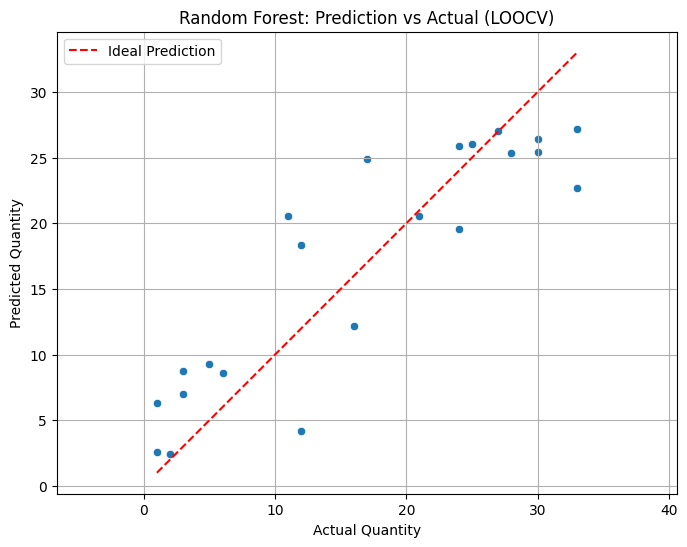


Evaluating Decision Tree with LOO
  Mean Squared Error (MSE): 38.09
  R² Score: 0.69


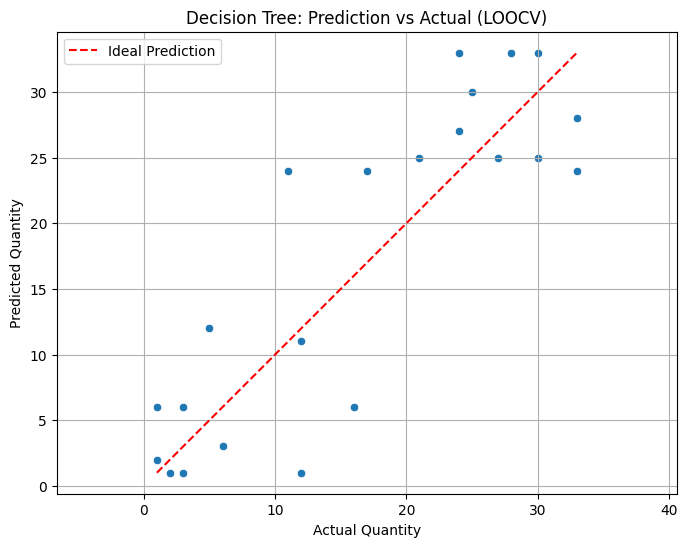


Best Performing Model: Random Forest with R² Score = 0.79


In [81]:
# Import required libraries
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/dsaproje/cleaned.csv")

# Convert order_date column to datetime format
df['order_date'] = pd.to_datetime(df['order_date'])

# Group by hour and aggregate relevant features
hourly_sales = df.groupby('hour').agg({
    'quantity': 'sum',
    'unit_price': 'mean',
    'guessed_gender': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'
}).reset_index()

# Define features and target variable
X = hourly_sales[['hour', 'unit_price', 'guessed_gender']]
y = hourly_sales['quantity']

# Encode categorical variables
X_encoded = pd.get_dummies(X, columns=['guessed_gender'], drop_first=True)

# Import machine learning models and tools
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize Leave-One-Out Cross Validation
loo = LeaveOneOut()

# Define models to evaluate
models_to_evaluate = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}

# Evaluate each model using LOOCV
for model_name, model in models_to_evaluate.items():
    print(f"\nEvaluating {model_name} with LOO")

    y_true, y_pred = [], []

    for train_index, test_index in loo.split(X_encoded):
        X_train, X_test = X_encoded.iloc[train_index], X_encoded.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if not X_train.empty and not y_train.empty:
            model.fit(X_train, y_train)
            prediction = model.predict(X_test)
            y_true.append(y_test.values[0])
            y_pred.append(prediction[0])
        else:
            print(f"Skipping split with empty training data for test index: {test_index}")

    # Compute performance metrics and visualize results
    if y_true and y_pred:
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        print(f"  Mean Squared Error (MSE): {mse:.2f}")
        print(f"  R² Score: {r2:.2f}")

        # Plot Actual vs Predicted
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=y_true, y=y_pred)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)],
                 color='red', linestyle='--', label='Ideal Prediction')
        plt.xlabel("Actual Quantity")
        plt.ylabel("Predicted Quantity")
        plt.title(f"{model_name}: Prediction vs Actual (LOOCV)")
        plt.legend()
        plt.grid(True)
        plt.axis('equal')
        plt.show()
    else:
        print(f"No predictions were made for {model_name} during LOOCV. Check data and splitting process.")
# Determine the best performing model based on R² score
model_scores = {}

for model_name in models_to_evaluate.keys():
    # Recalculate R² for consistency
    y_pred = []
    for train_index, test_index in loo.split(X_encoded):
        X_train, X_test = X_encoded.iloc[train_index], X_encoded.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = models_to_evaluate[model_name]
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        y_pred.append(prediction[0])

    score = r2_score(y, y_pred)
    model_scores[model_name] = score

# Identify the model with the highest R² score
best_model = max(model_scores, key=model_scores.get)
print(f"\nBest Performing Model: {best_model} R² Score = {model_scores[best_model]:.2f}")
